In [6]:
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [60]:
csv_path = "../data/inpg_dataset/csv_data/predis-mhi.csv"
feature_name = "conso_global"
window_size = 24
step = 24

## Build dataset
each day if forecasted using the value of the same day in from previous week

In [61]:
load = pd.read_csv(csv_path, sep=";")

In [62]:
load

,date_time,conso_global
0,1/1/2016 00:00:00,0.000000
1,1/1/2016 01:00:00,0.000000
2,1/1/2016 02:00:00,1.000000
3,1/1/2016 03:00:00,1.000000
4,1/1/2016 04:00:00,0.000000
...,...,...
59266,10/5/2022 10:00:00,3.999793
59267,10/5/2022 11:00:00,5.001383
59268,10/5/2022 12:00:00,4.000128
59269,10/5/2022 13:00:00,4.000000


984 1008


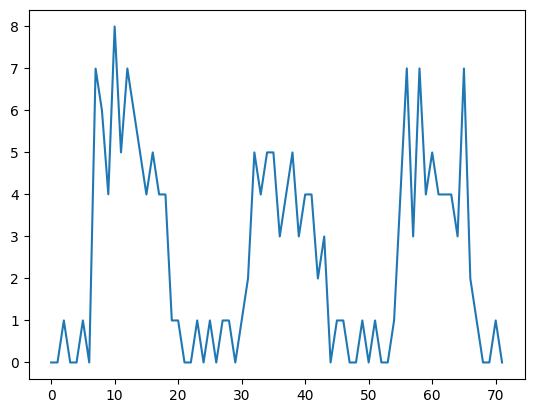

1224 1248


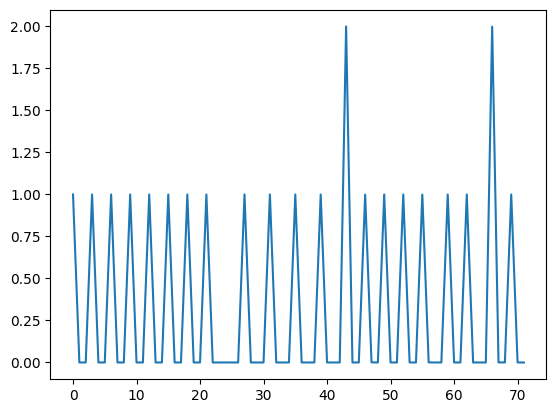

1368 1392


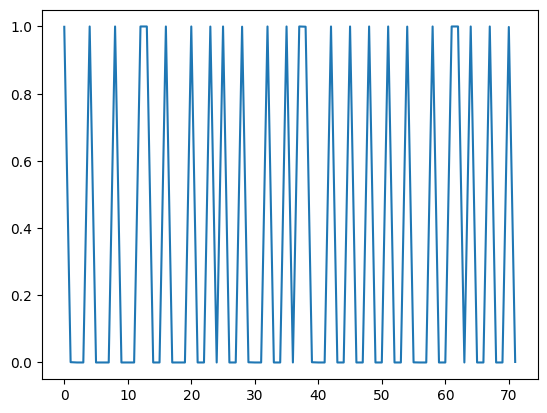

1632 1656


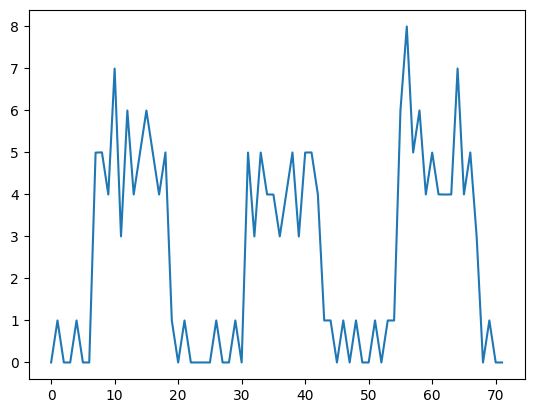

1320 1344


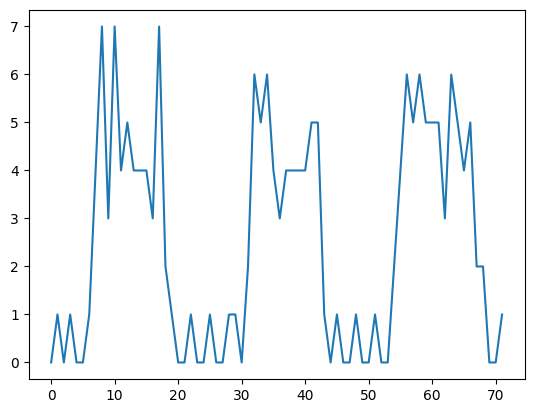

1488 1512


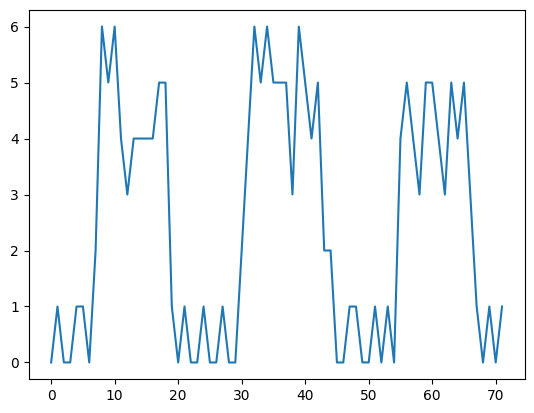

792 816


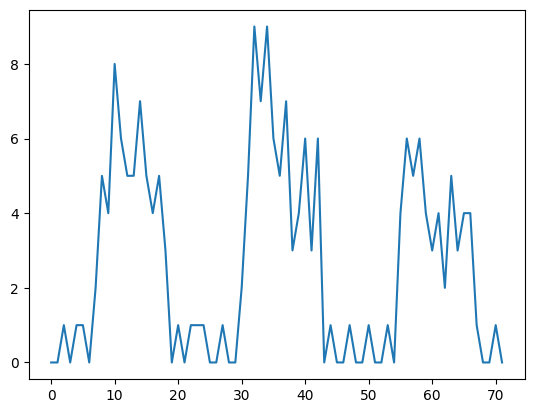

1680 1704


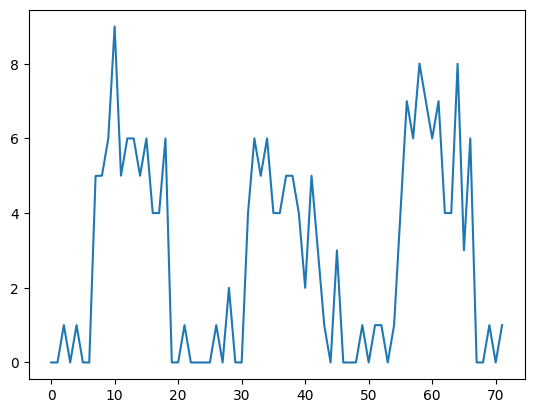

576 600


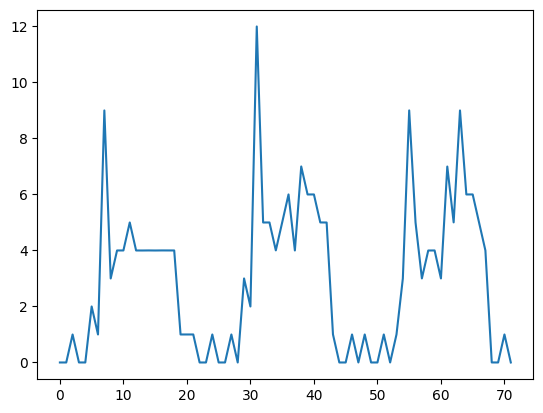

720 744


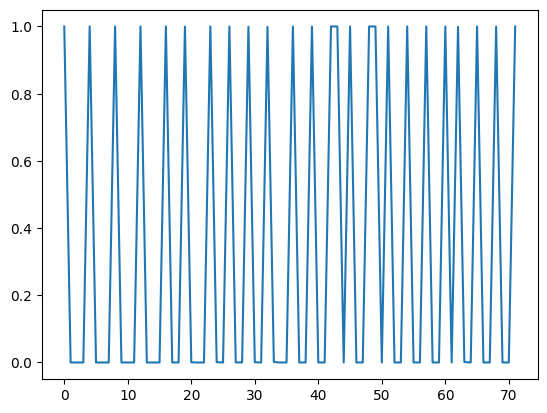

In [110]:
def get_feature(day0):
    # day0 = 24*10
    sequence = []

    start = day0
    end = start + window_size

    for day in range(3):
        sequence.extend(load[feature_name].values[start: end])
        start += 24*7
        end += 24*7
    # plt.plot(sequence)
    return sequence, start, end


data = []
for _ in range(10):
    r = np.random.randint(50)
    day0 = r*24
    sequence, start, end = get_feature(day0)
    data.append(sequence)
    print(start, end)
    plt.plot(sequence)
    plt.show()
    


## Synthesizing reallistic power anomalies

In [111]:
data = np.array(data)

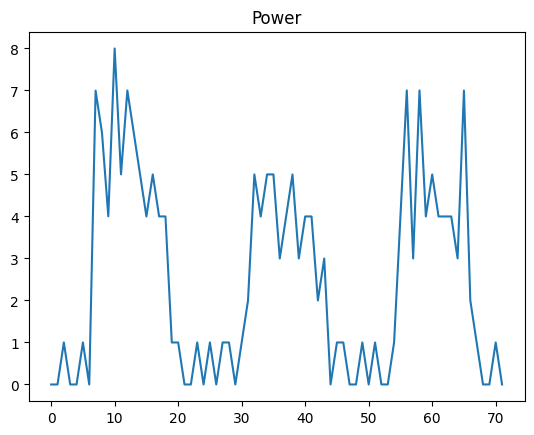

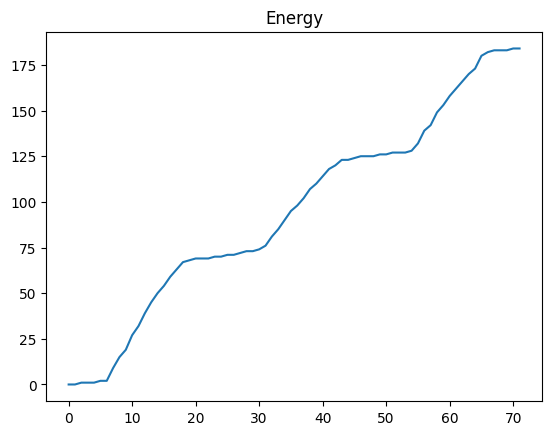

In [126]:
power = data[0]
energy = np.cumsum(power)
plt.plot(power)
plt.title("Power")
plt.show()

plt.plot(energy)
plt.title("Energy")
plt.show()

In [136]:
def _anomaly_type1(target, indices, lengths, k=0):
    """
    Anomaly type 1 that drops the power time series values to a negative value potentially followed by zero values
    before adding the missed sum of power to the end of the anomaly.
    """
    for idx, length in zip(indices, lengths):
        if length <= 2:
            raise Exception("Type 1 power anomalies must be longer than 2.")
        else:
            # WARNING: This could lead to a overflow quite fast?
            energy_at_start = target[:idx].sum() + k
            energy_at_end = target[:idx + length].sum() + k
            target[idx] = -1 * energy_at_start  # replace first by negative peak
            target[idx + 1:idx + length - 1] = 0  # set other values to zero
            target[idx + length - 1] = energy_at_end  # replace last with sum of missing values + k
    return target

def _anomaly_type2(target, indices, lengths, softstart=True):
    """
    Anomaly type 2 that drops the power time series values to potentially zero and adds the missed sum of power to
    the end of the anomaly.
    """
    for idx, length in zip(indices, lengths):
        if length <= 1:
            raise Exception("Type 2 power anomalies must be longer than 1.")
        else:
            if softstart:
                r = np.random.rand()
                energy_consumed = target[idx:idx + length].sum()
                target[idx] = r * target[idx]
                target[idx + 1:idx + length - 1] = 0
                target[idx + length - 1] = energy_consumed - target[idx]
            else:
                energy_consumed = target[idx:idx + length].sum()
                target[idx:idx + length - 1] = 0
                target[idx + length - 1] = energy_consumed
    return target

def _anomaly_type3(target, indices, lengths,
                    is_extreme=False, range_r=(0.01, 3.99), k=0):
    """
    Anomaly type 3 that creates a negatives peak in the power time series.
    """
    for idx, length in zip(indices, lengths):
        if length > 1:
            raise Exception("Type 3 power anomalies can't be longer than 1.")
        else:
            if is_extreme:
                energy_consumed = target[:idx].sum()
                target[idx] = -1 * energy_consumed - k
            else:
                r = np.random.uniform(*range_r)
                target[idx] = -1 * r * target[idx - 1]
    return target

def _anomaly_type4(target, indices, lengths, range_r=(0.01, 3.99)):
    """
    Anomaly type 4 that creates a positive peak in the power time series.
    """
    for idx, length in zip(indices, lengths):
        if length > 1:
            raise Exception("Type 4 power anomalies can't be longer than 1.")
        else:
            r = np.random.uniform(*range_r)
            target[idx] = r * target[idx - 1]
    return target


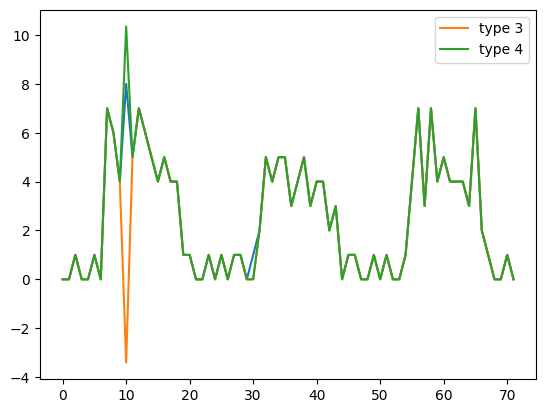

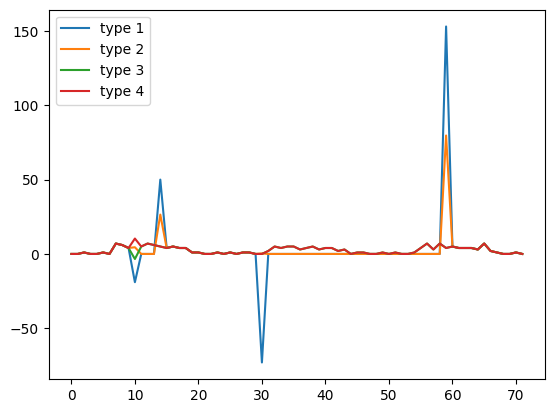

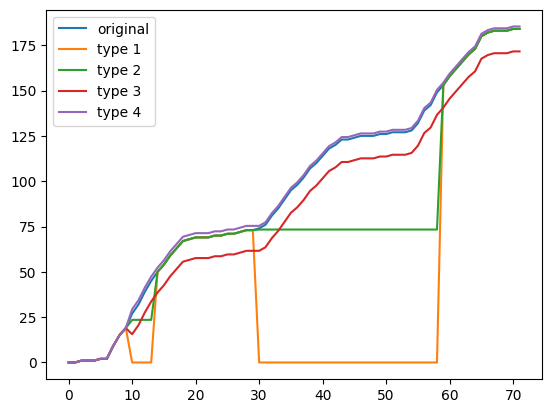

In [158]:
anomalous_power_type_1 = _anomaly_type1(power.copy(), [10, 30], [5, 30])
anomalous_power_type_2 = _anomaly_type2(power.copy(), [10, 30], [5, 30])
anomalous_power_type_3 = _anomaly_type3(power.copy(), [10, 30], [1, 1])
anomalous_power_type_4 = _anomaly_type4(power.copy(), [10, 30], [1, 1])

plt.plot(power)
# plt.plot(anomalous_power_type_1, label="type 1")
# plt.plot(anomalous_power_type_2, label="type 2")
plt.plot(anomalous_power_type_3, label="type 3")
plt.plot(anomalous_power_type_4, label="type 4")
plt.legend()
plt.show()

plt.plot(anomalous_power_type_1, label="type 1")
plt.plot(anomalous_power_type_2, label="type 2")
plt.plot(anomalous_power_type_3, label="type 3")
plt.plot(anomalous_power_type_4, label="type 4")
plt.legend()
plt.show()

energy = np.cumsum(power)
anomalous_energy_1 = np.cumsum(anomalous_power_type_1)
anomalous_energy_2 = np.cumsum(anomalous_power_type_2)
anomalous_energy_3 = np.cumsum(anomalous_power_type_3)
anomalous_energy_4 = np.cumsum(anomalous_power_type_4)
plt.plot(energy, label="original")
plt.plot(anomalous_energy_1, label="type 1")
plt.plot(anomalous_energy_2, label="type 2")
plt.plot(anomalous_energy_3, label="type 3")
plt.plot(anomalous_energy_4, label="type 4")
plt.legend()
plt.show()

change type 4 to make it more extreme?

[18, 31, 12] [6, 12, 4]


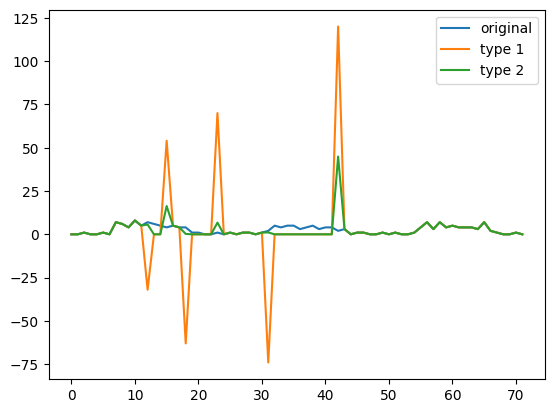

In [181]:
def get_anom_params(anom_per_seq=3, anom_type=1, max_lenth=10):
    anomalous_indices = []
    anomalous_lengths = []
    for _ in range(anom_per_seq):
        if anom_type==1 or anom_type==2:
            length = np.random.randint(3, max_lenth)
            idx = np.random.randint(1, len(power) - length)
            anomalous_lengths.append(length)
            anomalous_indices.append(idx)
        if anom_type==3 or anom_type==4: 
            idx = np.random.randint(1, len(power) - 1)
            anomalous_indices.append(idx)
            anomalous_lengths.append(1)
    return anomalous_indices, anomalous_lengths

anomalous_indices, anomalous_lengths = get_anom_params(anom_per_seq=3, anom_type=1, max_lenth=30)
print(anomalous_indices, anomalous_lengths)

anomalous_power_type_1 = _anomaly_type1(power.copy(), anomalous_indices, anomalous_lengths)
anomalous_power_type_2 = _anomaly_type2(power.copy(), anomalous_indices, anomalous_lengths)
# anomalous_power_type_3 = _anomaly_type3(power.copy(), anomalous_indices, anomalous_lengths)
# anomalous_power_type_4 = _anomaly_type4(power.copy(), anomalous_indices, anomalous_lengths)

plt.plot(power, label="original")
plt.plot(anomalous_power_type_1, label="type 1")
plt.plot(anomalous_power_type_2, label="type 2")
# plt.plot(anomalous_power_type_3, label="type 3")
# plt.plot(anomalous_power_type_4, label="type 4")
plt.legend()
plt.show()